<a href="https://colab.research.google.com/github/arkincognito/PyTorch/blob/main/10_02_VGG_for_CIFAR10_Multicore_TPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VGG

This notebook shows basic structure of VGG nets, and several versions of custom VGG nets for CIFAR10 dataset.

##CNN Parameters
Recap of CNN parameters
* Kernel Size(K): Size of the filter
* Stride(S): The amount of frames the filter move on the input
* Padding Size(P): Pad of zeros added around the border of the input. This provides control over output size.
* Channel Numbers(C): Number of filters applied to the input.

Output Size after a CNN Layer for $N\times N$ input:
$${N+2P-K\over S}+1$$
Number of Parameters in the CNN Layer:
$$channels\times (weights + bias) = C\times (K \times K + 1)$$

## What is VGGnet?
![VGGNet outline](https://blogfiles.pstatic.net/20160709_69/laonple_1468026496381NVR0l_PNG/VGGNet.png?type=w2)<br>
VGG net is a deep(at the time) CNN model with various depth modifications.<br>
VGG net uses $3 \times 3$ kernels with 1 stride for each convolution layer.<br>
Two consecutive $3 \times 3$ convolution layer output have the same feature map size as the output of a single $5 \times 5$ covolution layer.<br>
However, the trainable parameters of these cases are 18 and 25.<br>
Three $3 \times 3$ convolution layer and a single $7 \times 7$ convolution layer share the same feature map size, but with 27 and 49 trainable parameters in each case.<br>
It is easy to say multiple CNN layers with smaller kernel can be trained faster than a single large kernel.<br>
Also, as the depth of the net grows, the non-linearity of the feature increases, leading to better classification features.

There are 6 variations suggested in the paper, with difference in the number of convolution layers.<br>
It is said that the deeper the net, the better the classification performance becomes.

## CIFAR10
CIFAR10 dataset is composed with RGB images and their labels: 'plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', and 'truck'.

CIFAR10 image shape is 32 pixels in height, 32 pixels in width, 3 channel.
`transorms.ToTensor()` transforms CIFAR10 image to tensors of 3 channel, 32 pixel height, 32 pixel width.

Extracting ./cifar10/cifar-10-python.tar.gz to ./cifar10
CIFAR10 data shape:  torch.Size([1, 3, 32, 32])


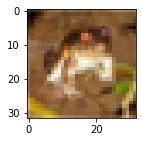


frog


In [ ]:
import torch
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
train_dataset = datasets.CIFAR10(root='./cifar10',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

loader = torch.utils.data.DataLoader(
      train_dataset,
      batch_size=1,
      drop_last=True)

for batch in loader: #load 1 batch of MNIST Training data and check its shape
  data, label = batch
  print('CIFAR10 data shape: ', data.shape)
  break
CLASSES = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')  
img = data[0]
npimg = img.numpy()
label = CLASSES[label.item()]
fig = plt.figure(figsize=(2,2))
plt.imshow(np.transpose(npimg, (1, 2, 0)))    
plt.show()
print(label)


We can see that the CIFAR10 data has 3 channels and $32\times 32$shape.

# Let's Code them

Enough with the theories.<br>
Let's start coding!<br>

## PyTorch/XLA preparation

As in [previous notebook]('https://colab.research.google.com/drive/1pBl22EzBXbaIBrO-lr8nkxnPGfCm-OLY#scrollTo=ej0qnTFC-p6m'), prepare Pytorch/XLA for Multi-Core TPU.


In [ ]:
import os
assert os.environ['COLAB_TPU_ADDR'], 'Make sure to select TPU from Edit > Notebook settings > Hardware accelerator'

In [ ]:
# Installs PyTorch, PyTorch/XLA, and Torchvision
# Copy this cell into your own notebooks to use PyTorch on Cloud TPUs 
# Warning: this may take a couple minutes to run
!pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.7-cp36-cp36m-linux_x86_64.whl

     |████████████████████████████████| 133.6MB 46kB/s 
     |████████████████████████████████| 61kB 3.6MB/s 
  Found existing installation: google-api-python-client 1.7.12
    Uninstalling google-api-python-client-1.7.12:
      Successfully uninstalled google-api-python-client-1.7.12


In [ ]:
import torch
import torch_xla
import torch_xla.core.xla_model as xm
import torch_xla.distributed.xla_multiprocessing as xmp
import torchvision
from torchvision import datasets
import torch.nn as nn
import torchvision.transforms as transforms
import torch_xla.distributed.parallel_loader as pl
import time

## Model
Here, we'll define VGG model builder.<br>
There are two components we haven't discussed before.<br>
* Adaptive Average Pool
* Kaiming Weight Initialization

### Adaptive Average Pooling
Average pooling that returns an output of designated shape.

### Kaiming Weight Initialization
Initialization method derived by [Kaiming et al](https://arxiv.org/pdf/1502.01852.pdf), by modeling non-linearity of ReLUs.<br>
Extremely deep models(>30 layers) can benefit from using Kaiming initialization.<br>
Below is the Kaiming initialization function:<br>
$$std = \sqrt{2 \over (1 + a^2) \times fan\_in}$$
Where
* a: the negative slope of the rectifier after this layer(0 for ReLU)
* fan_in: # of input dimension.

### FC layer size
Original VGGNet has 512 channel layer as the last convolution layer, followed by two FC layers with 4096 nodes and a classification layer, provisioned for 1000 class classification.<br>
However, we only have 10 classes and don't need 4096 nodes in FC layer. so, we'll reduce the FC layer to 2048 and 1024 nodes, and end the convolution layer with 256 channels. 

In [ ]:
import torchvision.models.vgg as vgg

class VGG(nn.Module):

    def __init__(self, features, num_classes=1000, init_weights=True):
        super(VGG, self).__init__()
        self.features = features
        #self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(256 * 4 * 4, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(2048, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(1024, num_classes),
        )
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        #x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

## Trainer

We'll define TPU multicore trainer.<br>
This trainer will return `training_history` and `validation_history`, as well as the `data`, `target`, and `pred` as in prediction of the last batch of data.<br>
We'll use training history and validation history to visualize training progress and see when **Overfitting** happens.
Data, Target, and Prediction of the last batch will be used to visualize the prediction of the model.

In [ ]:
def train_model(net):
  ## Setup 
  # Sets a common random seed - both for initialization and ensuring graph is the same
  torch.manual_seed(FLAGS['seed'])
  # Acquires the (unique) Cloud TPU core corresponding to this process's index
  device = xm.xla_device()
  ## Dataloader construction
  # Downloads train and test datasets
  # Note: master goes first and downloads the dataset only once (xm.rendezvous)
  #   all the other workers wait for the master to be done downloading.
  transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
  
  if not xm.is_master_ordinal():
    xm.rendezvous('download_only_once')

  train_dataset = datasets.CIFAR10(root='./cifar10',
                          train=True,
                          transform=transform,
                          download=True)

  test_dataset = datasets.CIFAR10(root='./cifar10',
                         train=False,
                         transform=transform,
                         download=True)
  
  if xm.is_master_ordinal():
    xm.rendezvous('download_only_once')

  # Creates the (distributed) train sampler, which let this process only access
  # its portion of the training dataset.
  train_sampler = torch.utils.data.distributed.DistributedSampler(
    train_dataset,
    num_replicas=xm.xrt_world_size(),
    rank=xm.get_ordinal(),
    shuffle=True)
  
  test_sampler = torch.utils.data.distributed.DistributedSampler(
    test_dataset,
    num_replicas=xm.xrt_world_size(),
    rank=xm.get_ordinal(),
    shuffle=True)
  
  # Creates dataloaders, which load data in batches
  # Note: test loader is not shuffled or sampled
  train_loader = torch.utils.data.DataLoader(
      train_dataset,
      batch_size=FLAGS['batch_size'],
      sampler=train_sampler,
      num_workers=FLAGS['num_workers'],
      drop_last=True)

  test_loader = torch.utils.data.DataLoader(
      test_dataset,
      batch_size=FLAGS['batch_size'],
      sampler=test_sampler,
      num_workers=FLAGS['num_workers'],
      drop_last=True)
  
  ## Network, optimizer, and loss function creation
  # Get model, loss function, and optimizer
  model = net.to(device)   
  loss_fn = torch.nn.CrossEntropyLoss()
  # Scale learning rate to world size
  lr = FLAGS['learning_rate'] * xm.xrt_world_size()
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  lr_sche = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.9)
  def train_loop_fn(loader):
    model.train()
    batch_num_total = len(loader)
    training_loss = 0
    total_samples = 0
    num_correct = 0
    training_accuracy = 0
    for batch_num, (data, targets) in enumerate(loader):
      output = model(data)
      loss = loss_fn(output, targets)
      optimizer.zero_grad()
      loss.backward()
      xm.optimizer_step(optimizer)
      training_loss += loss / batch_num_total
      pred = output.max(1, keepdim=True)[1]
      # num_correct += pred.eq(targets.view_as(pred)).sum().item()
      num_correct = pred.eq(targets.view_as(pred)).sum().item()
      # total_samples += data.size()[0]
      accuracy = 100.0 * num_correct / data.size()[0]
      training_accuracy += accuracy
    # training_accuracy = 100.0 * num_correct / total_samples
    training_accuracy = training_accuracy / batch_num_total
    return training_accuracy, training_loss
        
  def test_loop_fn(loader):
    model.eval()
    batch_num_total = len(loader)
    total_samples = 0
    num_correct = 0
    validation_loss = 0
    for batch_num, batch in enumerate(loader):
      data, targets = batch
      output = model(data)
      loss = loss_fn(output, targets)
      validation_loss += loss / batch_num_total
      pred = output.max(1, keepdim=True)[1]
      num_correct += pred.eq(targets.view_as(pred)).sum().item()
      total_samples += data.size()[0]
    validation_accuracy = 100.0 * num_correct / total_samples
    return validation_accuracy, validation_loss, data, pred, targets

  # Train and eval loops
  training_history = []
  evaluating_history = []
  for epoch in range(1, FLAGS['num_epochs'] + 1):
    para_loader = pl.ParallelLoader(train_loader, [device])
    training_accuracy, training_loss = train_loop_fn(para_loader.per_device_loader(device))
    para_loader = pl.ParallelLoader(test_loader, [device])
    validation_accuracy, validation_loss, data, pred, targets  = test_loop_fn(para_loader.per_device_loader(device))
    training_history.append(training_loss.tolist())
    evaluating_history.append(validation_loss.tolist())
    if FLAGS['metrics_debug']:
      xm.master_print(met.metrics_report(), flush=True)
    
    # xm.master_print('Epoch %d/%d\ttraining accuracy: %.4f\tvalidation accuracy: %.4f'
    # % epoch % FLAGS['num_epochs'] % training_accuracy % validation_accuracy)
    print('Device #', xm.get_ordinal(),', Epoch', epoch,'/', FLAGS['num_epochs'], '\ttraining accuracy: ', training_accuracy,\
          '\tvalidation accuracy: ', validation_accuracy)
  return training_accuracy, training_history, validation_accuracy, evaluating_history, data, pred, targets

## Plot Helpers
First, import files to build plot helpers and set the font color and font size.

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['axes.unicode_minus'] = False
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
import seaborn as sns
# %matplotlib inline
SMALL_SIZE = 10
MEDIUM_SIZE = 15
LARGE_SIZE = 18

plt.rc('font', size=SMALL_SIZE) # Default text sizes
plt.rc('axes', titlesize=LARGE_SIZE) # Axes title fontsize
plt.rc('axes', labelsize=MEDIUM_SIZE) # x and y labels' fontsize
plt.rc('xtick', labelsize=SMALL_SIZE) # x tick label size
plt.rc('ytick', labelsize=SMALL_SIZE) # y tick label size
plt.rc('legend', fontsize=SMALL_SIZE) # Legend fontsize
plt.rc('figure', titlesize=LARGE_SIZE) # Figure title size

COLOR = 'white'
mpl.rcParams['text.color'] = 'black' # Default text color(including legend)
mpl.rcParams['axes.labelcolor'] = COLOR # Axes label color
mpl.rcParams['axes.titlecolor'] = COLOR # Subplot Title Color
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR

### Prediction Visualization Helper

In [ ]:
'''train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=0,
    drop_last=True)

# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
preds = [1,2,4,8]
preds = torch.FloatTensor(preds)
plot_results(images, labels, preds)'''

'train_loader = torch.utils.data.DataLoader(\n    train_dataset,\n    batch_size=4,\n    shuffle=True,\n    num_workers=0,\n    drop_last=True)\n\n# get some random training images\ndataiter = iter(train_loader)\nimages, labels = dataiter.next()\npreds = [1,2,4,8]\npreds = torch.FloatTensor(preds)\nplot_results(images, labels, preds)'

In [ ]:
# Result Visualization Helper
import math
import numpy as np

M, N = 4, 6
RESULT_IMG_PATH = '/tmp/test_result.png'
CLASSES = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
def plot_results(images, labels, preds):
  print('start of plot_result')
  images, labels, preds = images[:M*N], labels[:M*N], preds[:M*N]
  print('i,l,p')
  # inv_norm = transforms.Normalize((-0.1307/0.3081,), (1/0.3081,))
  num_images = images.shape[0]
  print('num_images')
  fig, axes = plt.subplots(M, N, figsize=(11, 9))
  fig.suptitle('Correct / Predicted Labels (Red text for incorrect ones)')
  print('fig, axes, suptitle set')
  for i, ax in enumerate(fig.axes):
    ax.axis('off')
    if i >= num_images:
      continue
    img, label, prediction = images[i], labels[i].int(), preds[i].int()
    img = img / 2 + 0.5 #unnormalize
    npimg = img.numpy()
    label, prediction = CLASSES[label.item()], CLASSES[prediction.item()]
    if label == prediction:
      ax.set_title(prediction, color='blue', fontsize=22)
    else:
      ax.set_title(
          '{}/{}'.format(label, prediction), color='red')
    print('imshow')
    ax.imshow(np.transpose(npimg, (1, 2, 0)))
  # print('image built')  
  print('saving image')
  plt.savefig(RESULT_IMG_PATH, transparent=True)
  print('file closed')
  return

### Training History Visualization Helper

In [ ]:
import pandas as pd

def graph_history(TH_PATH, EH_PATH, net_names, ylim=(0,0.3), show_move_avg=True):  
  training_histories = pd.read_csv(TH_PATH, sep=',')
  evaluation_histories = pd.read_csv(EH_PATH, sep=',')
  fig = plt.figure(figsize=(15,8))
  tr_col_names = [net_name + '_train_loss' for net_name in net_names]
  ev_col_names = [net_name + '_eval_loss' for net_name in net_names] 
  tl_plot = sns.lineplot(data=training_histories[tr_col_names], dashes=[(2, 2) for _ in net_names], linewidth=2)
  el_plot = sns.lineplot(data=evaluation_histories[ev_col_names], dashes=False, linewidth=2)
  tl_plot.set(ylim=ylim)
  el_plot.set(ylim=ylim)
  if show_move_avg:
    moving_average_cols = []
    for net_name in ev_col_names:
      evaluation_histories[net_name + '_moving_average'] = evaluation_histories[net_name].rolling(5).mean().shift(-2)
      moving_average_cols.append(net_name + '_moving_average')
    el_average_plot = sns.lineplot(data=evaluation_histories[moving_average_cols], dashes=[(5, 2) for _ in moving_average_cols], linewidth=2)
    el_average_plot.set(ylim=ylim)
  plt.show()

### Training Process
Training histories will be saved into csv files.

In [ ]:
# Start training processes
def _mp_fn(rank, flags, NETS, NET_NAMES):
  global FLAGS
  FLAGS = flags
  torch.set_default_tensor_type('torch.FloatTensor')
  training_histories = {}
  evaluation_histories = {}
  
  for net, net_name in zip(NETS, NET_NAMES):
    start_time = time.time()
    training_accuracy, training_history, validation_accuracy, evaluating_history, data, pred, targets = train_model(net)
    training_histories[net_name + '_train_loss'] = training_history
    evaluation_histories[net_name + '_eval_loss'] = evaluating_history
    if rank == 0:
      print('------------------------------------------------------')
      print('------------------------------------------------------')
      print(net_name, ' Training complete. Training Time: ', time.time() - start_time)
      print('Training Accuracy: ', training_accuracy, 'Validation Accuracy: ', validation_accuracy)
      print('------------------------------------------------------')
      print('------------------------------------------------------')
  if rank == 0:
    training_histories = pd.DataFrame(training_histories)
    evaluation_histories = pd.DataFrame(evaluation_histories)
    print('history update')
    training_histories.to_csv(TH_PATH, sep=',', float_format = '%.6f')
    evaluation_histories.to_csv(EH_PATH, sep=',', float_format = '%.6f')
    print('plot update')
    # Retrieve tensors that are on TPU core 0 and plot.
    plot_results(data.cpu(), targets.cpu(), pred.cpu())

## Net Depth vs Performance


In [ ]:
# Configures training (and evaluation) parameters
FLAGS = {}
FLAGS['num_workers'] = 8
FLAGS['batch_size'] = 8 ## changing CIFAR10 Tensor from TPU to CPU with batch size of 16 doesn't work in google colab pro TPU
FLAGS['num_epochs'] = 40
FLAGS['seed'] = 0
FLAGS['learning_rate'] = 0.000625
FLAGS['num_cores'] = 8
FLAGS['metrics_debug'] = False
FLAGS['drop_rate'] = 0.5
# cfg = {
#     'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'], #8 + 3 =11 == vgg11
#     'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'], # 10 + 3 = vgg 13
#     'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'], #13 + 3 = vgg 16
#     'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'], # 16 +3 =vgg 19
#     'custom' : [64,64,64,'M',128,128,128,'M',256,256,256,'M']
# }
cfg = {
    'Custom7_BN': [32, 'M', 64,'M', 128, 256, 'M'],
    'Custom9_BN': [32, 32, 'M', 64, 64,'M', 128, 256, 'M'],
    'Custom11_BN': [32, 32, 'M', 64, 64,'M', 128, 128, 256, 256, 'M'],
    'Custom13_BN': [32, 32, 32, 'M', 64, 64, 64, 'M', 128, 128, 256, 256, 'M']
}

NET_NAMES = [key for key in cfg.keys()]
NETS = [VGG(vgg.make_layers(cfg[net_name], True),10,True) for net_name in NET_NAMES]

## Model Summary
`torchsummary.summary` summarizes the model, providing output shapes of each layer, parameter number in each layer, total number of parameters in the model, etc.<br>

In [ ]:
from torchsummary import summary
for net, net_name in zip(NETS, NET_NAMES):
  print(net_name, ' summary')
  summary(net, (3, 32, 32))

Custom7_BN  summary
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
         MaxPool2d-4           [-1, 32, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          18,496
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
         MaxPool2d-8             [-1, 64, 8, 8]               0
            Conv2d-9            [-1, 128, 8, 8]          73,856
      BatchNorm2d-10            [-1, 128, 8, 8]             256
             ReLU-11            [-1, 128, 8, 8]               0
           Conv2d-12            [-1, 256, 8, 8]         295,168
      BatchNorm2d-13            [-1, 256, 8, 8]             512
             ReLU-1

In [ ]:
TH_PATH = '/tmp/training_histories.csv'
EH_PATH = '/tmp/evaluation_histories.csv'

xmp.spawn(_mp_fn, args=(FLAGS, NETS, NET_NAMES), nprocs=FLAGS['num_cores'], start_method='fork')

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Device # 5 , Epoch 1 / 40 	training accuracy:  43.96606914212548 	validation accuracy:  58.17307692307692
Device # 0 , Epoch 1 / 40 	training accuracy:  43.34186939820743 	validation accuracy:  57.131410256410255
Device # 1 , Epoch 1 / 40 	training accuracy:  43.72599231754161 	validation accuracy:  62.33974358974359
Device # 2 , Epoch 1 / 40 	training accuracy:  43.66197183098591 	validat

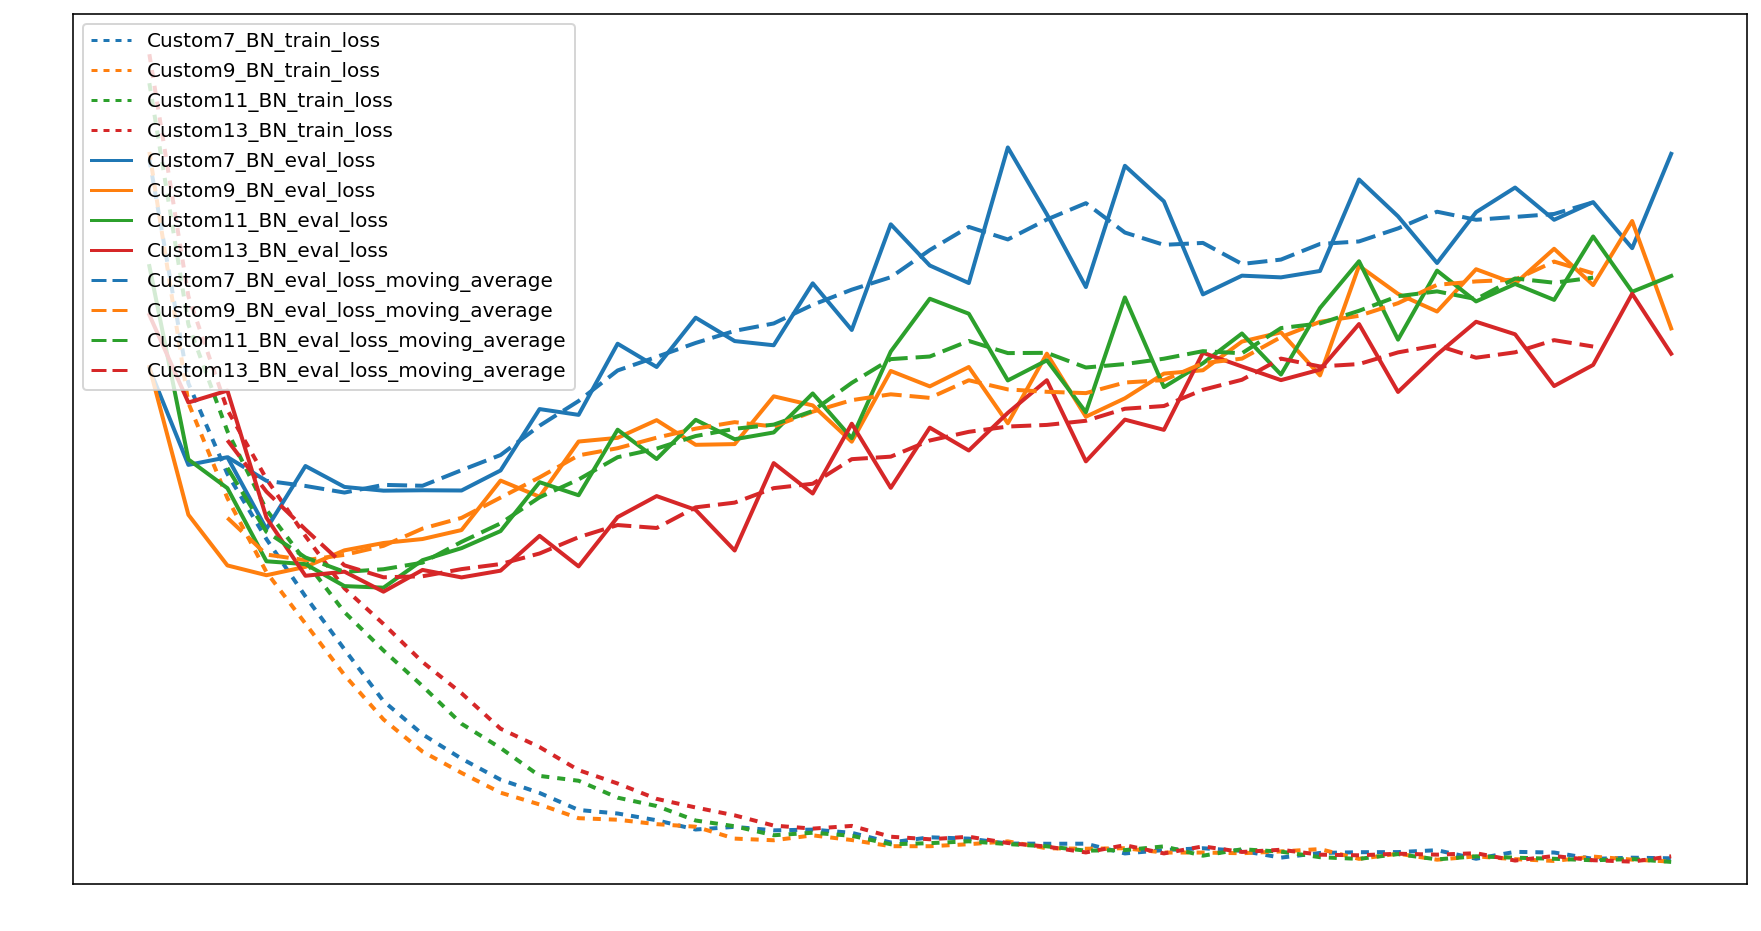

In [ ]:
graph_history(TH_PATH, EH_PATH, NET_NAMES, ylim=(0,None), show_move_avg=True)

## Results
We can see that **overfitting** starts around 5th epoch.<br>
Generally speaking, the deeper the net is, better the performance against overfitting.<br>
Most of the trainable parameters come from the FC layers, so I believe that in regards of convolution layers in VGG nets, more the layer, the better.

## Prediction Visualization

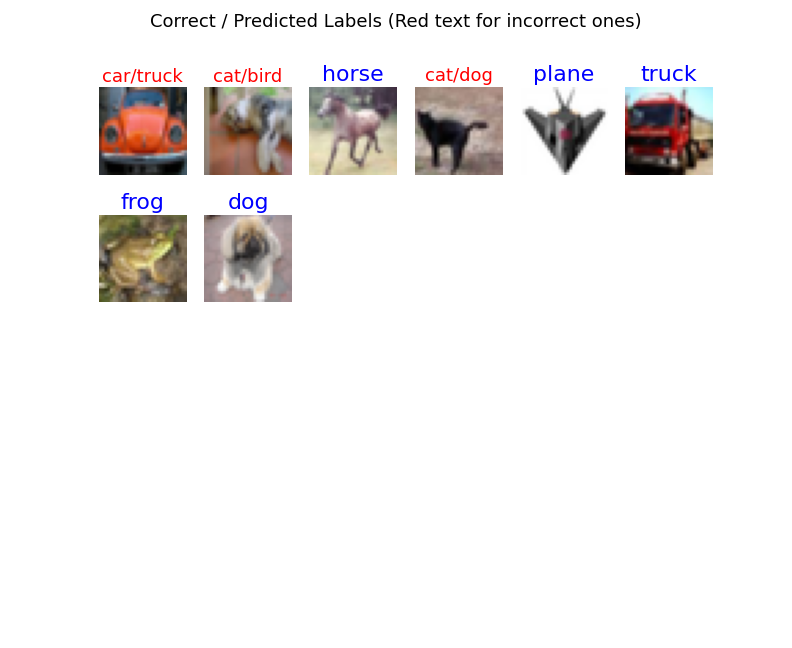

In [ ]:
from google.colab.patches import cv2_imshow
import cv2
img = cv2.imread(RESULT_IMG_PATH, cv2.IMREAD_UNCHANGED)
cv2_imshow(img)